In [8]:
import json
import pandas as pd
import seaborn as sns
import re
import pickle
# import mowl
# mowl.init_jvm("4g")
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt

## Load depth graph


In [9]:
big_G = {}

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

big_G = read_json_file("../../Data/Output/MeSH_graph_with_depth.json")

print(big_G.nodes["D004628"]["Depth"])

1


## Frequency analysis of MeSH terms in RELISH abstracts

We will load a json file that contains all the MeSH terms that are mentioned in pubmed abstracts

In [10]:
df_TP = pd.DataFrame()
MeSH_cnt = {}

'''
    Function to load the complete topic_categorization dataset.
    https://drive.google.com/file/d/19C9rI3HFKqxD4eX8XhV87g0-ImITqm96/view?usp=sharing

    Input:  path -> The path location of the topic_categorization dataset in tsv format.
    Output: A DataFrame with the topic_categorization dataset "PMID", "Title/Abstract", "MeshTerms","SemanticTypes"
'''
def load_Dataset(path):
    global df_TP
    df_TP = pd.read_csv(path,sep='\t')
    print(df_TP.head())

load_Dataset("../../Data/Input/pubmed_abstracts+MeSH+STY_dataset.tsv")

       PMID                                     Title/Abstract  \
0  34694464  limit use dithionit quench determin topolog me...   
1  34694463  isol post traumat astereognosi case base revie...   
2  34694462  loss chromatin remodel ddm caus segreg distort...   
3  34694461  identif novel genom wide pleiotrop associ oral...   
4  34694460  rare frequent lethal complic pulmonari vein is...   

                         MeshTerms             SemanticTypes  
0                  D005456;D008565       T130;T192;T116;T123  
1                  D006225;D013236                 T039;T023  
2                  D017360;D029681                 T116;T002  
3                          D058685                 T028;T045  
4  D001281;D017115;D004937;D011667  T023;T047;T046;T190;T061  


In [11]:
big_G_nodes = set([x[0] for x in list(big_G.nodes.items())])

for k in big_G_nodes:
    if(k not in MeSH_cnt):
        MeSH_cnt[k] = 0

'''
    Function  count of the appearances of a MeSH terms in the pubmed_abstracts+MeSH+STY dataset.

    Input:  
    Output: A Dictionary with the  count of the appearances of a MeSH, when an MeSH appears its parents as well appear   
            {MeSH id : CNT}
'''
def count_MeSH_in_Dataset():
    for i in df_TP.index: 
        #print(df_semantic["Semantic Types"][i])
        split_types = df_TP["MeshTerms"][i].split(";")
        #print(split_types)
        for MeSH in split_types:
            if MeSH in big_G_nodes:
                graph_id = MeSH
                if(graph_id in MeSH_cnt):
                    MeSH_cnt[graph_id] = MeSH_cnt[graph_id] + 1
                else:
                    MeSH_cnt[graph_id] = 1

    #print(sorted(MeSH_cnt.items(), key=lambda kv:(-kv[1], -kv[0])))

count_MeSH_in_Dataset()

In [12]:
nx.set_node_attributes(big_G, MeSH_cnt, "Frequency_Pubmed")
print(big_G.nodes["D000067565"]["Frequency_Pubmed"])

849


In [13]:
with open("../../Data/Output/RELISH_MeSH_graph_with_depth+freq.json", "w") as fp:
            json.dump(json_graph.node_link_data(big_G),fp,indent = 2) 

## Frequency visualization

    Depth in Mesh Tree  MeSH count
0                    1       61284
1                    2      843644
2                    3     1932853
3                    4     1692144
4                    5      710946
5                    6      205559
6                    7       83324
7                    8       54233
8                    9       40488
9                   10       23677
10                  11        3608
11                  12        2149
12                  13        2310


[Text(0.5, 1.0, 'MeSH depth frequencies in Pubmed abstracts')]

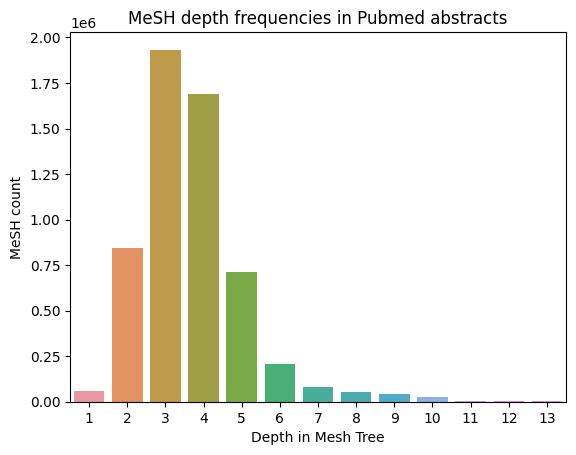

In [14]:
i = 0
Depth_vs_freq = {}
for node_id in big_G.nodes:
    if(node_id in big_G_nodes and MeSH_cnt[node_id] != 0):
        dpth = big_G.nodes[node_id]["Depth"]
        freq = big_G.nodes[node_id]["Frequency_Pubmed"]
        if(dpth in Depth_vs_freq): Depth_vs_freq[dpth] += freq
        else: Depth_vs_freq[dpth] = freq        
        i+=1
    # if(i == 20): break

sortedKeys = list(Depth_vs_freq.keys())
sortedKeys.sort()
Depth_vs_freq = {i: Depth_vs_freq[i] for i in sortedKeys}

df_Depth_vs_freq = pd.DataFrame()
df_Depth_vs_freq['Depth in Mesh Tree'] = list(Depth_vs_freq.keys())
df_Depth_vs_freq['MeSH count'] = list(Depth_vs_freq.values())

print(df_Depth_vs_freq)
sns.barplot(df_Depth_vs_freq, x="Depth in Mesh Tree", y="MeSH count").set(title='MeSH depth frequencies in Pubmed abstracts')